In [3]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [4]:
df = pd.read_csv('/kaggle/input/netflix-amir/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df['Rating'] = df['Rating'].astype(float)

print(format(df.shape))
print(df.iloc[::1000000, :])

(24058263, 2)
          Cust_Id  Rating
0              1:     NaN
1000000    953667     4.0
2000000   1910904     5.0
3000000   2068490     4.0
4000000    496631     3.0
5000000   2560324     4.0
6000000   1091776     4.0
7000000    990917     4.0
8000000   1177065     2.0
9000000    593351     4.0
10000000  2271935     2.0
11000000   490101     3.0
12000000   700005     2.0
13000000  1668869     5.0
14000000  1947241     5.0
15000000  1921803     2.0
16000000   956220     4.0
17000000    18949     3.0
18000000   460528     3.0
19000000   693477     4.0
20000000  1933327     3.0
21000000  1336822     3.0
22000000  1878057     3.0
23000000  1215779     2.0
24000000   517002     4.0


<ipython-input-5-64a842b368fc>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_count = df.isnull().sum()[1]
<ipython-input-5-64a842b368fc>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')


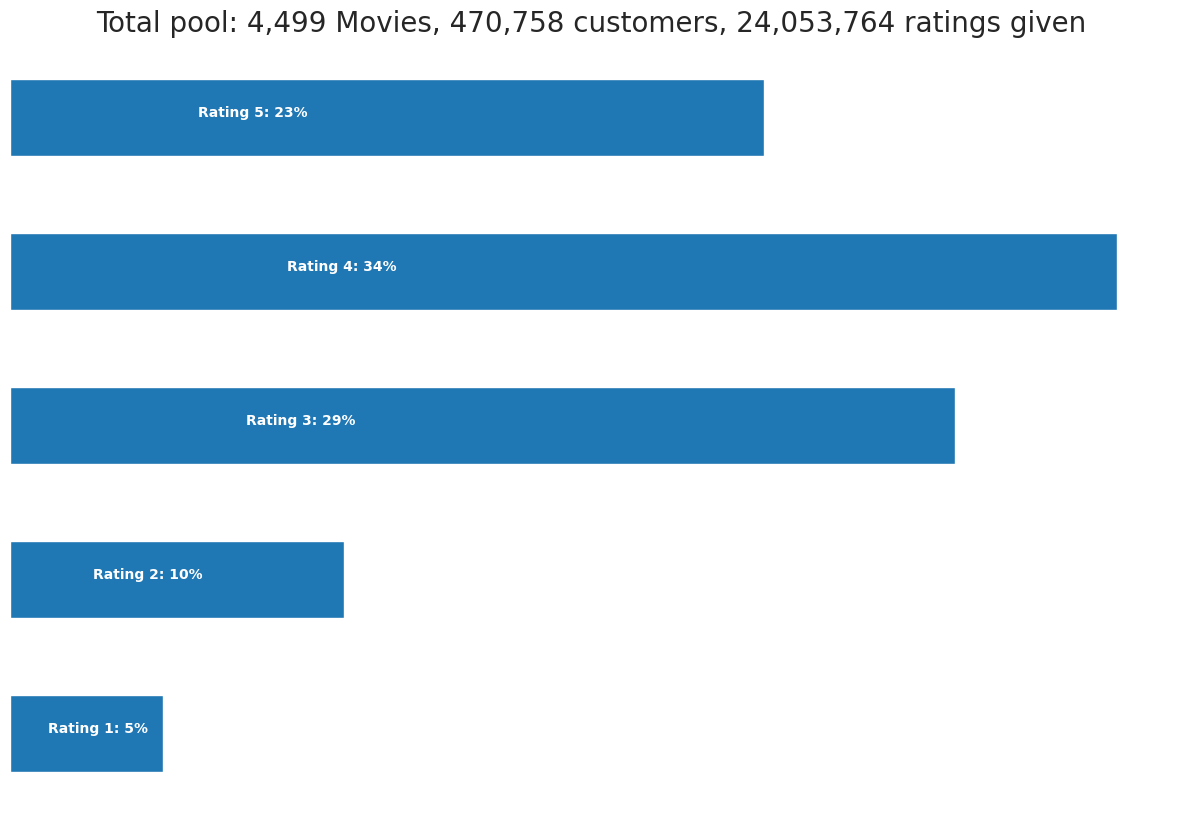

In [5]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [6]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print(format(movie_np))
print(format(len(movie_np)))

[1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
24053764


In [7]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print(df.iloc[::1000000, :])

          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
1000225   1424777     3.0       225
2000361   1176424     4.0       361
3000564   2288257     3.0       564
4000759    432983     3.0       759
5000996    501954     2.0       996
6001180   1760220     3.0      1180
7001406   1957786     4.0      1406
8001602   1300982     3.0      1602
9001798   1973661     5.0      1798
10001962   404654     5.0      1962
11002136  1548324     2.0      2136
12002340   741670     3.0      2340
13002462   929327     5.0      2462
14002690   484565     4.0      2690
15002876   886608     2.0      2876
16003106  2235049     2.0      3106
17003282  2590741     2.0      3282
18003427   562860     1.0      3427
19003624   644825     4.0      3624
20003825  1193835     2.0      3825
21003938  1733776     5.0      3938
22004141  1191317     4.0      4141
23004331  2571337     1.0      4331
24004488   163209     3.0      4488


In [8]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1799.0
Customer minimum times of review: 52.0


In [9]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print(df.iloc[::1000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (17337458, 3)
          Cust_Id  Rating  Movie_Id
696        712664     5.0         3
1374441   1300759     4.0       295
2766827   1746056     4.0       494
4110584   1662445     4.0       788
5473490    953111     3.0      1110
6932490   1299309     5.0      1384
8297227   1488466     4.0      1650
9636748   2467323     4.0      1890
11061852  2040374     3.0      2152
12491164  2235049     3.0      2391
13860273   400155     3.0      2660
15249127  2432905     3.0      2922
16618125  1979820     5.0      3223
18022909  2318315     5.0      3433
19356266  2639676     3.0      3684
20766530   466962     4.0      3923
22197443   261620     3.0      4210
23556158   971769     3.0      4402


In [10]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(143458, 1350)


In [15]:
df_title = pd.read_csv('/kaggle/input/netflix-amir/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'],on_bad_lines='skip')
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


In [18]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:200000], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.98678533, 0.99471517, 0.98519577, 0.9924238 , 0.993638  ]),
 'test_mae': array([0.78106351, 0.78312588, 0.77964825, 0.78355851, 0.80040826]),
 'fit_time': (3.183725118637085,
  3.3163044452667236,
  3.3277556896209717,
  3.2432191371917725,
  3.2520434856414795),
 'test_time': (0.23575806617736816,
  0.22174978256225586,
  4.646621465682983,
  4.687626123428345,
  4.742915868759155)}

lets see  what customer 656399 likes 

In [19]:
df_656399 = df[(df['Cust_Id'] == 656399) & (df['Rating'] == 5)]
df_656399 = df_656399.set_index('Movie_Id')
df_656399 = df_656399.join(df_title)['Name']
print(df_656399)

Movie_Id
571                                  American Beauty
1245                                       Threesome
1590                                 Life as a House
1707    Outfoxed: Rupert Murdoch's War on Journalism
3986                                   Life and Debt
Name: Name, dtype: object


lets see what model is recommending to the customer 65399

In [28]:
user_2271935 = df_title.copy()
user_2271935 = user_2271935.reset_index()
user_2271935 = user_2271935[~user_2271935['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_2271935['Estimate_Score'] = user_2271935['Movie_Id'].apply(lambda x: svd.predict(2271935, x).est)

user_2271935 = user_2271935.drop('Movie_Id', axis = 1)

user_2271935 = user_2271935.sort_values('Estimate_Score', ascending=False)
print(user_2271935.head(10))

        Year                                         Name  Estimate_Score
173   1992.0                               Reservoir Dogs        4.435167
857   1954.0                                Seven Samurai        4.335198
2067  1994.0                       The Simpsons: Season 6        4.232475
3381  2002.0                                Spirited Away        4.182200
1735  1995.0                                Trainspotting        4.173184
3092  2000.0             Monty Python: The Life of Python        4.162136
3379  2004.0        Family Guy: Freakin' Sweet Collection        4.143614
2078  2002.0                                      Firefly        4.128653
2729  1974.0  Pink Floyd: Live at Pompeii: Director's Cut        4.126768
197   1978.0                              The Deer Hunter        4.124471


making a function to recommend movies based on another movies that customer likes

In [33]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [38]:
#example 

recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                  Name  count     mean
 1.000000                                      X2: X-Men United  98720 3.932202
 0.384550                              Batman Beyond: The Movie   2614 3.726855
 0.375967                                        Justice League   3591 3.710944
 0.361393                      Justice League: Justice on Trial   2961 3.718001
 0.338025                    Batman Beyond: Return of the Joker   3704 3.604752
 0.335256                                         Batman Begins  54922 4.236699
 0.328229                          Batman: Mask of the Phantasm   2823 3.767977
 0.327040 Batman: The Animated Series: Tales of the Dark Knight   2432 3.583059
 0.316666                       Dragon Ball Z: Super Android 13   2426 3.428689
 0.316166                              Mortal Kombat: The Movie   7633 3.165466
